In [2]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import scipy as sp
import pvalannot
#import statsmodels
from sklearn.decomposition import PCA
from sklearn import preprocessing
from statsmodels.stats import multitest

In [3]:
groupDf = []

for group in [0, 1, 2, 3]:
    df = pd.read_csv("KIR_Group_%d_final_genotype.tsv"%group, sep="\t")
    df["sample"] = df["sample"].map(lambda x: x.split("_")[0])
    groupDf.append(df)

In [17]:
groupDf[1]

,sample,KIR2DL1*003,KIR2DL3*001,KIR2DL4*001,KIR2DS4*001,KIR3DL1*015,KIR3DL1*020,KIR3DL2*002,KIR3DL2*009,inconsistency
0,SRR6298286,0.000000,1.014971,0.000000,0.000000,0.000000,0.000000,3.405995,0.000000,NaN
1,SRR6298287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.348771,NaN
2,SRR6298288,0.000000,43.516845,0.000000,127.692817,4.877936,0.000000,0.000000,124.631392,NaN
3,SRR6298289,0.000000,683.789933,4.051864,352.437680,11.267130,50.702089,66.027042,192.078123,NaN
4,SRR6298290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.130790,0.000000,NaN
5,SRR6298291,11.599166,58.184346,9.724384,74.482756,37.979089,0.000000,113.404970,229.289329,NaN
6,SRR6298292,0.000000,700.397374,13.366066,1208.151217,0.000000,145.606373,208.569808,447.266401,NaN
7,SRR6298293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.689373,0.000000,NaN
8,SRR6298294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.359783,18.969908,NaN
9,SRR6298295,2.615519,20.870338,0.000000,0.000000,0.000000,0.000000,20.708446,5.177111,NaN


In [4]:
sraToPhenotype = {}

srxToSrr = {}
srrToPhenotype = {}
fp = open("PRJNA418779_29Immune_SraRunInfo.csv")
line = fp.readline()
for line in fp:
    cols = line.rstrip().split(",")
    if (len(cols) > 1):
        srxToSrr[cols[10]] = cols[0]
fp.close()   

fp = open("PRJNA418779_29Immune_sra_result.csv")
line = fp.readline()
for line in fp:
    cols = line.rstrip().split(",")
    for i, c in enumerate(cols):
        cols[i] = c[1:-1]
    if (len(cols) > 1):
        #print(cols)
        srr = srxToSrr[cols[0]]
        phenotype = "_".join(cols[1].split(";")[0].split(" ")[1].split("_"))
        srrToPhenotype[srr] = phenotype
fp.close()

In [9]:
(pd.DataFrame.from_dict(srrToPhenotype, orient="index")).to_csv("srrToPhenotype.tsv", sep="\t")

In [23]:
for srr in srrToPhenotype:
    if ("CD4" in srrToPhenotype[srr]):
        print(srr, srrToPhenotype[srr])

SRR6298363 G4YW_CD4_naive_rep3
SRR6298329 9JD4_CD4_TE_rep1
SRR6298328 9JD4_CD4_naive_rep1
SRR6298300 925L_CD4_TE_rep2
SRR6298299 925L_CD4_naive_rep2
SRR6298271 DZQV_CD4_naive_rep4


In [5]:
for i, df in enumerate(groupDf):
    df["phenotype"] = [srrToPhenotype[s] for s in df["sample"]] 
    groupDf[i] = df.drop(columns = ["inconsistency", "sample"], axis=1)

In [42]:
groupDf[0]

,KIR2DL1*003,KIR2DL2*003,KIR2DL3*001,KIR2DL4*005,KIR2DL4*011,KIR2DL5B*002,KIR2DS1*002,KIR2DS2*001,KIR3DL1*005,KIR3DL2*007,KIR3DL2*010,KIR3DS1*013,phenotype
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CD8_naive
1,0.000000,4.359198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.138340,CD8_CM
2,45.306692,0.000000,183.519088,44.570502,0.000000,37.458743,0.000000,0.000000,72.134520,114.445888,481.284189,559.332217,CD8_TE
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MAIT
4,21.588470,27.518283,74.265892,2.838605,0.000000,25.651466,28.486418,102.097507,72.743327,72.810853,58.248683,312.608121,VD2+
5,31.597557,0.000000,84.299281,20.752678,0.000000,114.109372,90.978401,326.331777,118.854937,848.470822,201.626848,1033.820952,VD2-
6,5.996484,2.706892,0.000000,0.000000,0.000000,3.257329,0.000000,6.420913,0.000000,17.711177,0.000000,6.127506,Treg
7,0.000000,1.743679,0.000000,0.000000,0.000000,3.257329,0.000000,0.000000,0.000000,0.000000,12.602171,22.924892,Th1
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.272311,13.964563,13.964582,10.584360,Th1/Th17
9,0.000000,0.000000,9.769094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.016350,0.000000,0.000000,Th17


In [19]:
groupDf[2]

,KIR2DL2*003,KIR2DL3*001,KIR2DL4*005,KIR2DL5B*002,KIR2DS1*002,KIR2DS2*001,KIR3DL2*007,KIR3DS1*013,phenotype
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,G4YW_CD8_naive_rep3
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.589989,16.523241,G4YW_CD8_CM_rep3
2,0.000000,0.000000,0.000000,10.586211,14.625222,24.017284,159.742437,168.853346,G4YW_CD8_EM_rep3
3,35.417740,17.774220,1.215559,20.765333,88.047492,70.419523,107.814099,401.098628,G4YW_CD8_TE_rep3
4,0.000000,0.000000,0.000000,0.000000,3.940887,0.000000,3.405995,3.162055,G4YW_MAIT_rep3
5,33.818574,14.171104,2.430965,35.424881,24.394598,40.881885,160.424361,527.426750,G4YW_VD2+_rep3
6,399.866191,43.790401,24.485043,246.985536,697.737512,289.602427,804.166866,2454.291448,G4YW_VD2-_rep3
7,0.000000,0.000000,0.000000,0.000000,0.000000,2.955665,28.610354,5.533597,G4YW_TFH_rep3
8,0.000000,0.000000,0.000000,0.000000,1.970443,3.940887,2.724796,22.608696,G4YW_Treg_rep3
9,0.000000,4.806030,0.000000,0.000000,4.148668,10.716747,7.560869,3.952569,G4YW_Th1_rep3


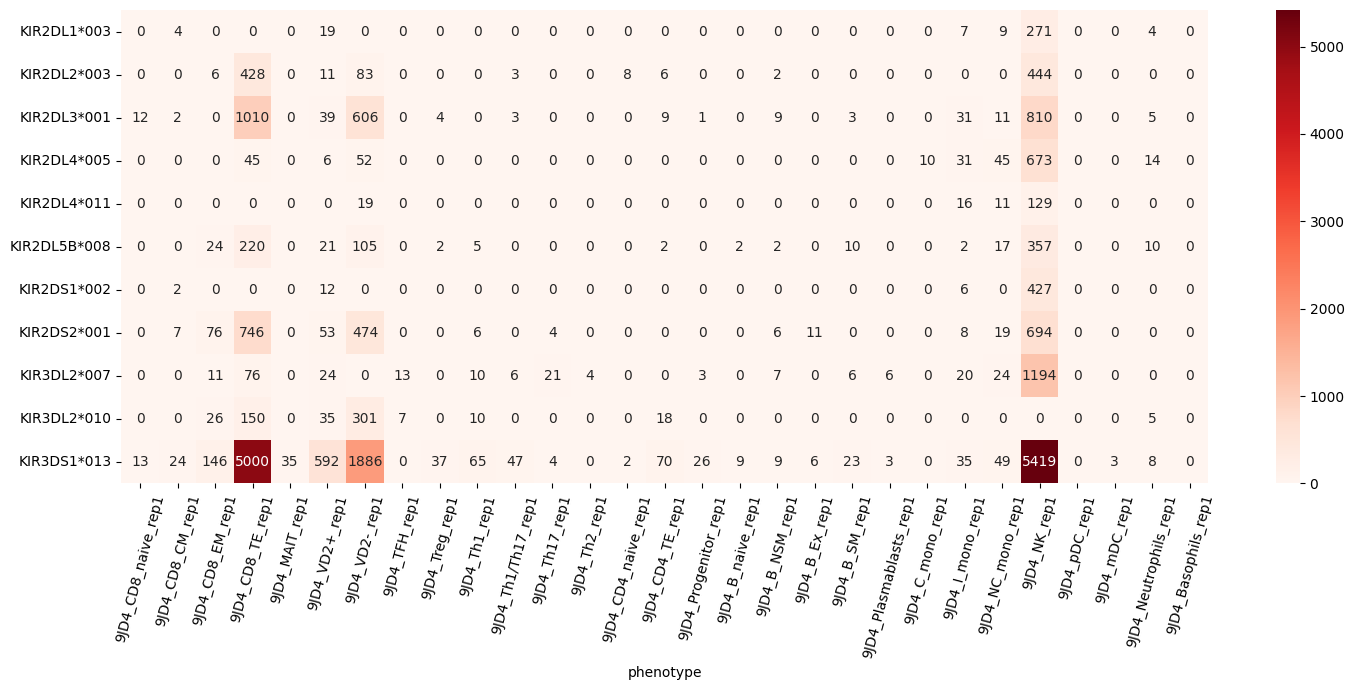

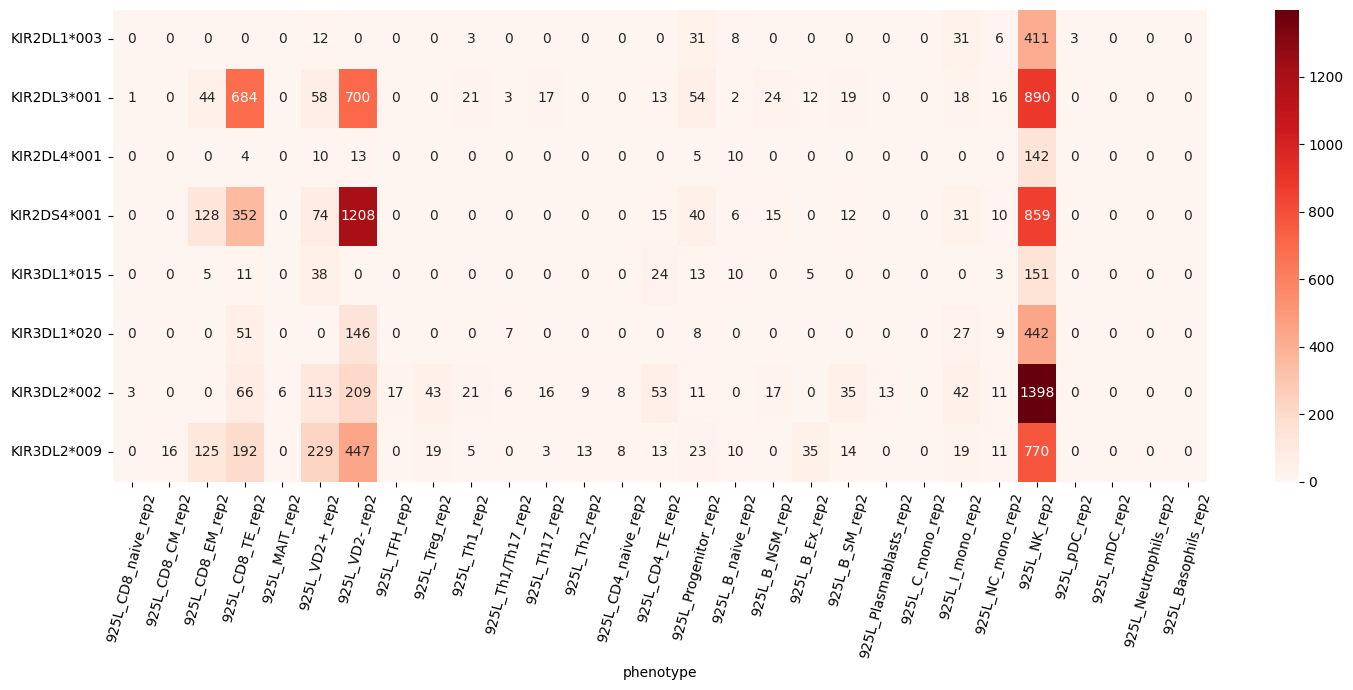

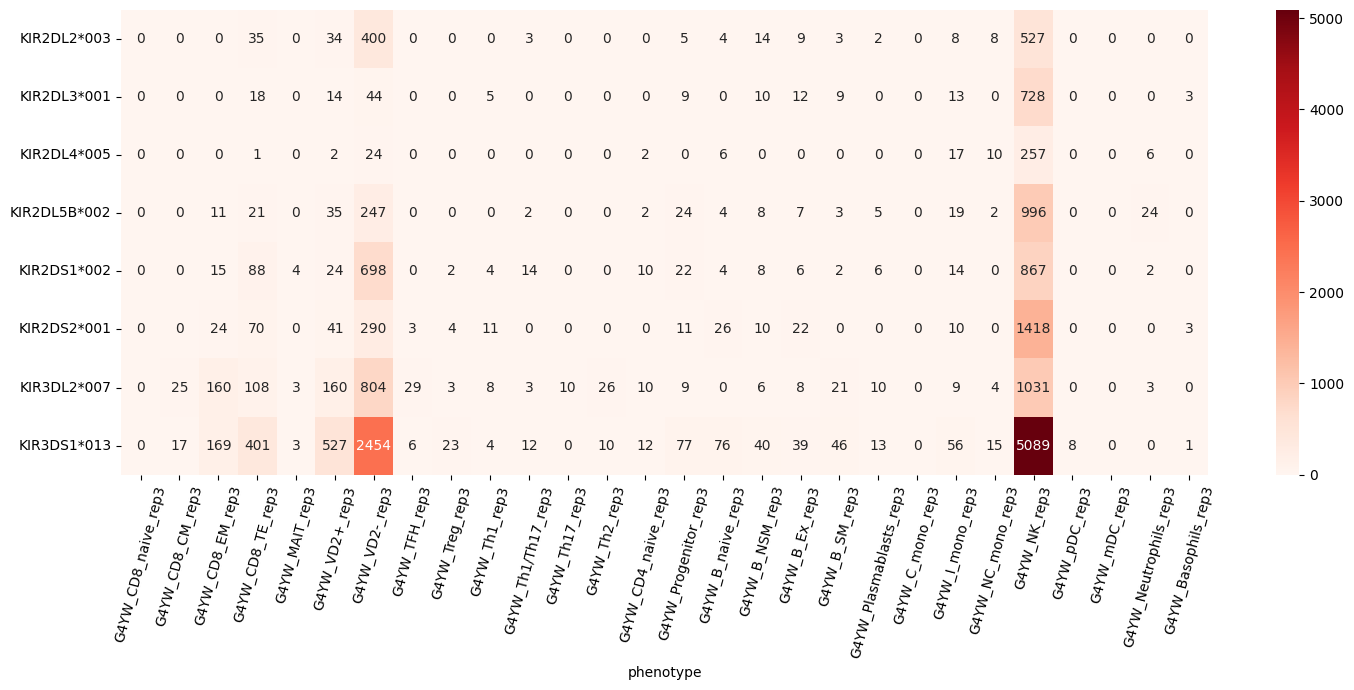

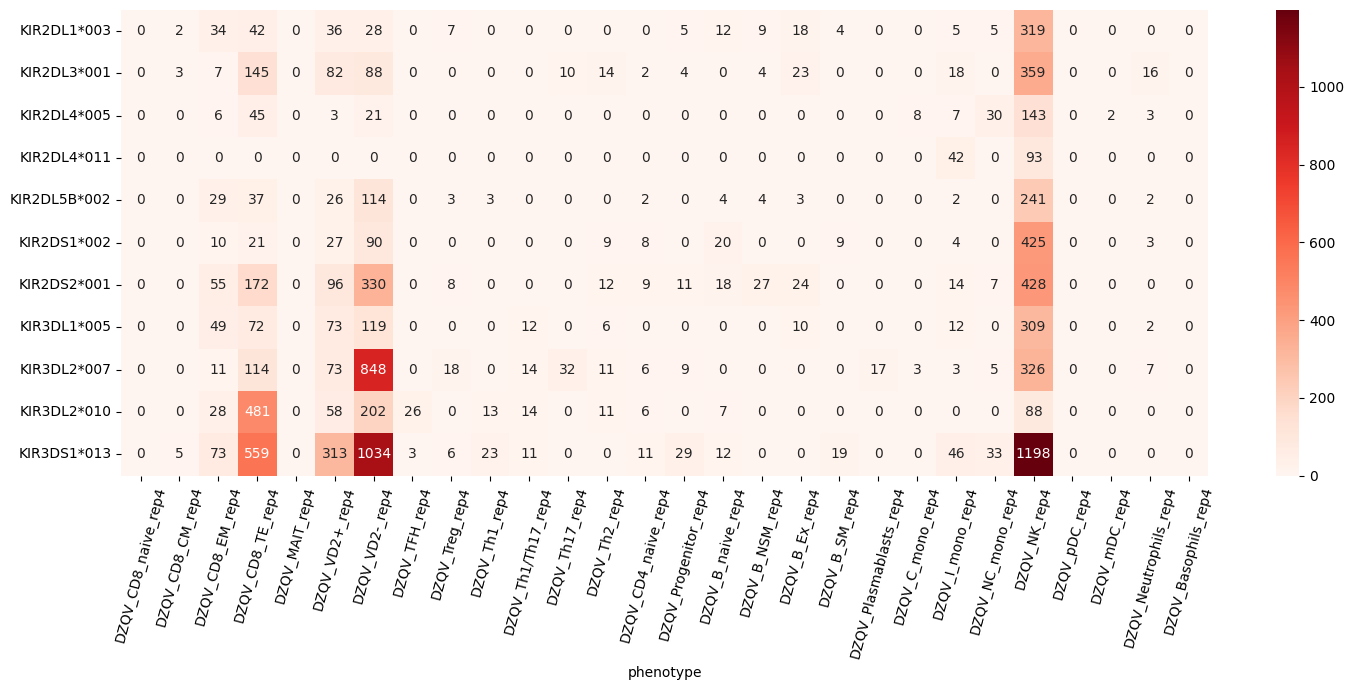

In [15]:
for i in range(4):
    df = groupDf[i].iloc[0:-1] # the last row is for PBMC cell, a non-immune cell
    heatmapDf = df.set_index("phenotype").transpose()
    plt.figure(figsize=(15, 7))
    snsFig = sns.heatmap(heatmapDf, cmap="Reds", fmt=".0f", annot=True)
    for tick in snsFig.get_xticklabels():
        tick.set_rotation(75)
    plt.tight_layout()
    #plt.savefig(f"smartseq_heatmap_group{i}.png", dpi=300)